In [6]:


from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score

from xgboost import XGBClassifier

PROC_DIR = Path("data/processed")
labeled_path = PROC_DIR / "features_labeled.parquet"

data = pd.read_parquet(labeled_path)
print(f"Loaded labeled data: {data.shape[0]:,} rows, {data.shape[1]} columns")
print("Campaigns:", sorted(data["product_name"].unique()))

# Target
TARGET_COL = "label_high_engagement"

# Baseline: account size only
BASELINE_FEATURES = [
    "log1p_user_followers",
    "log1p_user_friends",
]

# Full model: size + network position (no direct engagement counts)
FULL_FEATURES = BASELINE_FEATURES + [
    "log1p_in_degree",
    "log1p_out_degree",
    "log1p_pagerank",
    "kcore",
]

print("\nBaseline feature columns:", BASELINE_FEATURES)
print("\nFull model feature columns:", FULL_FEATURES)

Loaded labeled data: 30,089 rows, 22 columns
Campaigns: ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']

Baseline feature columns: ['log1p_user_followers', 'log1p_user_friends']

Full model feature columns: ['log1p_user_followers', 'log1p_user_friends', 'log1p_in_degree', 'log1p_out_degree', 'log1p_pagerank', 'kcore']


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier

# Pick one campaign here
CAMPAIGN = "spark_thinking"   # change as needed

df_c = data[data["product_name"] == CAMPAIGN].copy()
print(f"Campaign: {CAMPAIGN}")
print(f"Total rows (candidates): {len(df_c):,}")

# Train/test split (same as before)
df_train, df_test = train_test_split(
    df_c,
    test_size=0.3,
    stratify=df_c[TARGET_COL],
    random_state=42,
)

def label_summary(name, df):
    n = len(df)
    pos = int(df[TARGET_COL].sum())
    neg = n - pos
    print(f"{name}: {n:5d} rows  "
          f"positives={pos:4d} ({pos/n:5.1%}),  "
          f"negatives={neg:4d} ({neg/n:5.1%})")

print("\nTrain/test split:")
label_summary("Train", df_train)
label_summary("Test ", df_test)

# Matrices
Xb_train = df_train[BASELINE_FEATURES].to_numpy()
Xb_test  = df_test[BASELINE_FEATURES].to_numpy()

Xf_train = df_train[FULL_FEATURES].to_numpy()
Xf_test  = df_test[FULL_FEATURES].to_numpy()

y_train = df_train[TARGET_COL].to_numpy()
y_test  = df_test[TARGET_COL].to_numpy()

# Helper: precision@k
def precision_at_k(y_true, y_score, k):
    k = min(k, len(y_true))
    idx = np.argsort(y_score)[::-1][:k]
    return float(y_true[idx].sum()) / k

def model_metrics(name, y_true, scores):
    y_pred = (scores >= 0.5).astype(int)
    return {
        "model": name,
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, scores),
        "p@50": precision_at_k(y_true, scores, 50),
        "p@100": precision_at_k(y_true, scores, 100),
    }

metrics = []
test_with_scores = df_test.copy()

# 1) Logistic, baseline features
sc_base = StandardScaler()
Xb_train_s = sc_base.fit_transform(Xb_train)
Xb_test_s  = sc_base.transform(Xb_test)

log_base = LogisticRegression(max_iter=1000, random_state=42)
log_base.fit(Xb_train_s, y_train)
p_log_base = log_base.predict_proba(Xb_test_s)[:, 1]
metrics.append(model_metrics("logistic_baseline", y_test, p_log_base))
test_with_scores["score_logistic_baseline"] = p_log_base

# 2) Logistic, full features
sc_full_log = StandardScaler()
Xf_train_s_log = sc_full_log.fit_transform(Xf_train)
Xf_test_s_log  = sc_full_log.transform(Xf_test)

log_full = LogisticRegression(max_iter=1000, random_state=42)
log_full.fit(Xf_train_s_log, y_train)
p_log_full = log_full.predict_proba(Xf_test_s_log)[:, 1]
metrics.append(model_metrics("logistic_full", y_test, p_log_full))
test_with_scores["score_logistic_full"] = p_log_full

# 3) XGBoost, full features
sc_full_xgb = StandardScaler()
Xf_train_s_xgb = sc_full_xgb.fit_transform(Xf_train)
Xf_test_s_xgb  = sc_full_xgb.transform(Xf_test)

xgb_full = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
)
xgb_full.fit(Xf_train_s_xgb, y_train)
p_xgb_full = xgb_full.predict_proba(Xf_test_s_xgb)[:, 1]
metrics.append(model_metrics("xgboost_full", y_test, p_xgb_full))
test_with_scores["score_xgb_full"] = p_xgb_full

print("\nTest metrics for campaign:", CAMPAIGN)
metrics_df = pd.DataFrame(metrics)
display(metrics_df)

# See top 10 test accounts by xgboost_full score
cols_show = [
    "user_id",
    "is_official_influencer",
    "user_followers",
    "total_engagement",
    "in_degree",
    "pagerank",
    TARGET_COL,
    "score_logistic_baseline",
    "score_logistic_full",
    "score_xgb_full",
]

print("\nTop 10 test accounts by xgboost_full score:")
display(
    test_with_scores.sort_values("score_xgb_full", ascending=False)[cols_show].head(10)
)

Campaign: spark_thinking
Total rows (candidates): 7,138

Train/test split:
Train:  4996 rows  positives=1060 (21.2%),  negatives=3936 (78.8%)
Test :  2142 rows  positives= 454 (21.2%),  negatives=1688 (78.8%)

Test metrics for campaign: spark_thinking


,model,f1,roc_auc,p@50,p@100
0,logistic_baseline,0.000000,0.623758,0.4,0.36
1,logistic_full,0.729763,0.889994,1.0,1.00
2,xgboost_full,0.727717,0.911015,1.0,1.00



Top 10 test accounts by xgboost_full score:


,user_id,is_official_influencer,user_followers,total_engagement,in_degree,pagerank,label_high_engagement,score_logistic_baseline,score_logistic_full,score_xgb_full
20060,104815,0,11350,2654,165,0.001559,1,0.224648,0.999999,0.999684
18133,83142,0,698524,2811,907,0.003817,1,0.347959,1.000000,0.999683
18893,88275,0,63501,80,22,0.000322,1,0.283495,0.998950,0.999681
20255,105746,0,18383,107,24,0.000252,1,0.237261,0.999096,0.999677
19470,97952,0,15122,28,17,0.000332,1,0.232878,0.997246,0.999653
21005,123443,0,145480,2577,206,0.001473,1,0.281977,1.000000,0.999652
18112,83087,0,186930,5524,526,0.005346,1,0.304200,1.000000,0.999630
18355,84395,0,23523,106,25,0.000377,1,0.240742,0.999284,0.999621
20864,119321,0,43224,655,80,0.000916,1,0.256487,0.999991,0.999619
18196,83448,0,25037,90,29,0.000360,1,0.241486,0.999601,0.999615


In [9]:
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBClassifier

PROC_DIR = Path("data/processed")

# Helper: precision at top k
def precision_at_k(y_true, y_score, k):
    k = min(k, len(y_true))
    idx = np.argsort(y_score)[::-1][:k]
    return float(y_true[idx].sum()) / k

# Helper: collect metrics for one model on one campaign
def model_metrics_row(campaign, name, y_true, scores):
    y_pred = (scores >= 0.5).astype(int)
    return {
        "product_name": campaign,
        "model": name,
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, scores),
        "p@50": precision_at_k(y_true, scores, 50),
        "p@100": precision_at_k(y_true, scores, 100),
    }

# Core function: run all three models for one campaign
def run_models_for_campaign(campaign_name):
    df_c = data[data["product_name"] == campaign_name].copy()
    print(f"\n=== Campaign: {campaign_name} ===")
    print(f"Total candidate accounts: {len(df_c):,}")

    # Train/test split
    df_train, df_test = train_test_split(
        df_c,
        test_size=0.3,
        stratify=df_c[TARGET_COL],
        random_state=42,
    )

    def label_summary(name, df):
        n = len(df)
        pos = int(df[TARGET_COL].sum())
        neg = n - pos
        print(f"{name}: {n:5d} rows  "
              f"positives={pos:4d} ({pos/n:5.1%}),  "
              f"negatives={neg:4d} ({neg/n:5.1%})")

    label_summary("Train", df_train)
    label_summary("Test ", df_test)

    # Feature matrices
    Xb_train = df_train[BASELINE_FEATURES].to_numpy()
    Xb_test  = df_test[BASELINE_FEATURES].to_numpy()

    Xf_train = df_train[FULL_FEATURES].to_numpy()
    Xf_test  = df_test[FULL_FEATURES].to_numpy()

    y_train = df_train[TARGET_COL].to_numpy()
    y_test  = df_test[TARGET_COL].to_numpy()

    metrics = []
    test_with_scores = df_test.copy()

    # 1) Logistic, baseline features
    sc_base = StandardScaler()
    Xb_train_s = sc_base.fit_transform(Xb_train)
    Xb_test_s  = sc_base.transform(Xb_test)

    log_base = LogisticRegression(max_iter=1000, random_state=42)
    log_base.fit(Xb_train_s, y_train)
    p_log_base = log_base.predict_proba(Xb_test_s)[:, 1]
    metrics.append(model_metrics_row(campaign_name, "logistic_baseline", y_test, p_log_base))
    test_with_scores["score_logistic_baseline"] = p_log_base

    # 2) Logistic, full features
    sc_full_log = StandardScaler()
    Xf_train_s_log = sc_full_log.fit_transform(Xf_train)
    Xf_test_s_log  = sc_full_log.transform(Xf_test)

    log_full = LogisticRegression(max_iter=1000, random_state=42)
    log_full.fit(Xf_train_s_log, y_train)
    p_log_full = log_full.predict_proba(Xf_test_s_log)[:, 1]
    metrics.append(model_metrics_row(campaign_name, "logistic_full", y_test, p_log_full))
    test_with_scores["score_logistic_full"] = p_log_full

    # 3) XGBoost, full features
    sc_full_xgb = StandardScaler()
    Xf_train_s_xgb = sc_full_xgb.fit_transform(Xf_train)
    Xf_test_s_xgb  = sc_full_xgb.transform(Xf_test)

    xgb_full = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
    )
    xgb_full.fit(Xf_train_s_xgb, y_train)
    p_xgb_full = xgb_full.predict_proba(Xf_test_s_xgb)[:, 1]
    metrics.append(model_metrics_row(campaign_name, "xgboost_full", y_test, p_xgb_full))
    test_with_scores["score_xgb_full"] = p_xgb_full

    return metrics, test_with_scores

# Run over all campaigns
all_metrics = []
all_preds = []

campaigns = sorted(data["product_name"].unique())
print("Campaigns to run:", campaigns)

for c in campaigns:
    m, preds = run_models_for_campaign(c)
    all_metrics.extend(m)

    # Keep only useful columns plus scores
    cols_keep = [
        "product_name",
        "user_id",
        "is_official_influencer",
        "user_followers",
        "total_engagement",
        "in_degree",
        "pagerank",
        TARGET_COL,
        "score_logistic_baseline",
        "score_logistic_full",
        "score_xgb_full",
    ]
    preds = preds[cols_keep].copy()
    all_preds.append(preds)

# Combine and save
metrics_df = pd.DataFrame(all_metrics)
preds_df = pd.concat(all_preds, ignore_index=True)

print("\nOverall metrics per campaign and model:")
display(metrics_df)

metrics_path = PROC_DIR / "model_metrics_per_campaign.parquet"
preds_path = PROC_DIR / "model_predictions_all_campaigns.parquet"

metrics_df.to_parquet(metrics_path, index=False)
preds_df.to_parquet(preds_path, index=False)

print(f"\nSaved metrics to: {metrics_path}")
print(f"Saved predictions to: {preds_path}")

print("\nSample of predictions (first 10 rows):")
display(preds_df.head(10))

Campaigns to run: ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']

=== Campaign: abc_reading ===
Total candidate accounts: 6,869
Train:  4808 rows  positives=1064 (22.1%),  negatives=3744 (77.9%)
Test :  2061 rows  positives= 456 (22.1%),  negatives=1605 (77.9%)

=== Campaign: electric_toothbrush ===
Total candidate accounts: 1,561
Train:  1092 rows  positives= 231 (21.2%),  negatives= 861 (78.8%)
Test :   469 rows  positives=  99 (21.1%),  negatives= 370 (78.9%)

=== Campaign: intelligent_floor_scrubber ===
Total candidate accounts: 5,959
Train:  4171 rows  positives= 934 (22.4%),  negatives=3237 (77.6%)
Test :  1788 rows  positives= 400 (22.4%),  negatives=1388 (77.6%)

=== Campaign: ruby_face_cream ===
Total candidate accounts: 3,059
Train:  2141 rows  positives= 490 (22.9%),  negatives=1651 (77.1%)
Test :   918 rows  positives= 210 (22.9%),  negatives= 708 (77.1%)

=== Campaign: spark_thinking ===

,product_name,model,f1,roc_auc,p@50,p@100
0,abc_reading,logistic_baseline,0.000000,0.596156,0.28,0.30
1,abc_reading,logistic_full,0.747141,0.890635,1.00,1.00
2,abc_reading,xgboost_full,0.762733,0.911802,1.00,1.00
3,electric_toothbrush,logistic_baseline,0.000000,0.612244,0.40,0.30
4,electric_toothbrush,logistic_full,0.890052,0.987005,1.00,0.87
5,electric_toothbrush,xgboost_full,0.911917,0.982774,1.00,0.91
6,intelligent_floor_scrubber,logistic_baseline,0.004963,0.603820,0.34,0.34
7,intelligent_floor_scrubber,logistic_full,0.757123,0.913352,1.00,1.00
8,intelligent_floor_scrubber,xgboost_full,0.746922,0.927784,0.98,0.99
9,ruby_face_cream,logistic_baseline,0.086580,0.589272,0.62,0.50



Saved metrics to: data/processed/model_metrics_per_campaign.parquet
Saved predictions to: data/processed/model_predictions_all_campaigns.parquet

Sample of predictions (first 10 rows):


,product_name,user_id,is_official_influencer,user_followers,total_engagement,in_degree,pagerank,label_high_engagement,score_logistic_baseline,score_logistic_full,score_xgb_full
0,abc_reading,103289,0,10979,1,1,0.000013,0,0.240230,0.050654,0.092501
1,abc_reading,87111,0,1340,1,1,0.000011,0,0.192864,0.048748,0.025721
2,abc_reading,208571,0,248,1,1,0.000016,0,0.167928,0.047386,0.013477
3,abc_reading,217491,0,391,1,1,0.000012,0,0.172703,0.045945,0.049530
4,abc_reading,118007,0,650,1,1,0.000033,0,0.179949,0.056474,0.081864
5,abc_reading,89924,0,41824,1,1,0.000018,0,0.250260,0.037224,0.020061
6,abc_reading,103422,0,992,3,1,0.000028,0,0.189478,0.044860,0.021555
7,abc_reading,85235,0,301369,6,2,0.000037,0,0.293376,0.181842,0.088021
8,abc_reading,89852,0,911853,2,1,0.000018,0,0.330838,0.034863,0.008140
9,abc_reading,213019,0,128,3,1,0.000107,0,0.163931,0.050532,0.023781


Summary: share of truly high-engagement accounts in the top 50 and top 100 picks


,campaign,method,share_good_in_top50,share_good_in_top100
0,abc_reading,Followers only,0.28,0.30
1,abc_reading,Followers + network (Logistic),1.00,1.00
2,abc_reading,Followers + network (XGBoost),1.00,1.00
3,electric_toothbrush,Followers only,0.40,0.30
4,electric_toothbrush,Followers + network (Logistic),1.00,0.87
5,electric_toothbrush,Followers + network (XGBoost),1.00,0.91
6,intelligent_floor_scrubber,Followers only,0.34,0.34
7,intelligent_floor_scrubber,Followers + network (Logistic),1.00,1.00
8,intelligent_floor_scrubber,Followers + network (XGBoost),0.98,0.99
9,ruby_face_cream,Followers only,0.62,0.50


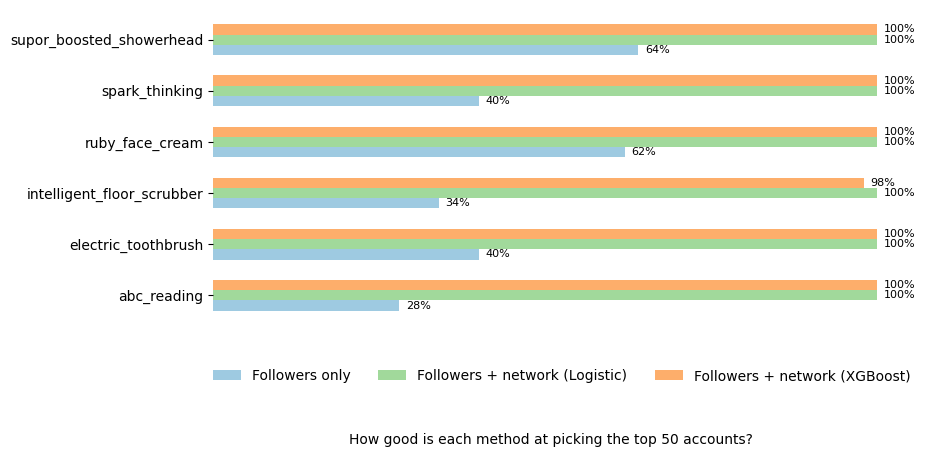

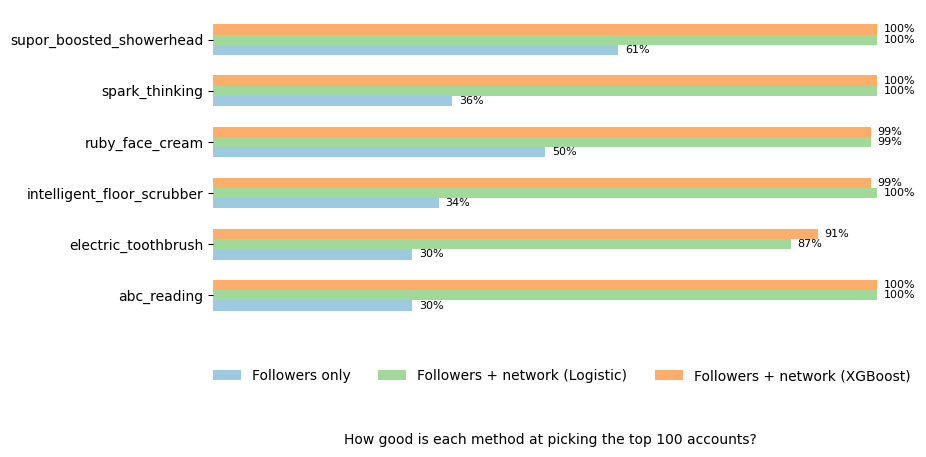

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Rebuild summary from metrics_df
model_label_map = {
    "logistic_baseline": "Followers only",
    "logistic_full": "Followers + network (Logistic)",
    "xgboost_full": "Followers + network (XGBoost)",
}

summary = metrics_df.copy()
summary["model_readable"] = summary["model"].map(model_label_map)

summary_show = summary[[
    "product_name",
    "model_readable",
    "p@50",
    "p@100",
]].rename(columns={
    "product_name": "campaign",
    "model_readable": "method",
    "p@50": "share_good_in_top50",
    "p@100": "share_good_in_top100",
})

print("Summary: share of truly high-engagement accounts in the top 50 and top 100 picks")
display(summary_show)

methods = [
    "Followers only",
    "Followers + network (Logistic)",
    "Followers + network (XGBoost)",
]

summary_plot_50 = summary_show.pivot(
    index="campaign",
    columns="method",
    values="share_good_in_top50",
).reindex(columns=methods)

summary_plot_100 = summary_show.pivot(
    index="campaign",
    columns="method",
    values="share_good_in_top100",
).reindex(columns=methods)

# Light colors
colors = ["#9ecae1", "#a1d99b", "#fdae6b"]  # light blue, green, orange

def plot_horizontal_bottom_title(summary_df, bottom_title):
    campaigns = summary_df.index
    n_campaigns = len(campaigns)

    height = 0.2
    y = np.arange(n_campaigns)

    fig, ax = plt.subplots(figsize=(9, 5))
    # Leave extra bottom space for legend + title text
    fig.subplots_adjust(bottom=0.25)

    for i, (method, color) in enumerate(zip(methods, colors)):
        values_pct = summary_df[method].values * 100.0
        y_pos = y + (i - 1) * height
        bars = ax.barh(y_pos, values_pct, height=height, label=method, color=color)

        for bar, val in zip(bars, values_pct):
            ax.text(
                bar.get_width() + 1,
                bar.get_y() + bar.get_height() / 2,
                f"{val:.0f}%",
                va="center",
                fontsize=8,
            )

    # Y labels and X limits
    ax.set_yticks(y)
    ax.set_yticklabels(campaigns)
    ax.set_xlim(0, 105)

    # No x ticks, no grid
    ax.set_xticks([])
    ax.grid(False)

    # No top title, no x-label
    ax.set_title("")
    ax.set_xlabel("")

    # Remove borders
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Legend just under the chart, horizontal
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.10),
        ncol=len(methods),
        frameon=False,
    )

    # Bottom title text, a bit below the legend
    fig.text(
        0.5,
        0.02,
        bottom_title,
        ha="center",
        va="center",
        fontsize=10,
    )

    plt.show()

# Chart for top 50
plot_horizontal_bottom_title(
    summary_plot_50,
    bottom_title="How good is each method at picking the top 50 accounts?",
)

# Chart for top 100
plot_horizontal_bottom_title(
    summary_plot_100,
    bottom_title="How good is each method at picking the top 100 accounts?",
)

In [18]:
import pandas as pd

# If preds_df is not in memory, load it
from pathlib import Path
PROC_DIR = Path("data/processed")
preds_path = PROC_DIR / "model_predictions_all_campaigns.parquet"
preds_df = pd.read_parquet(preds_path)

# Choose which score we treat as the final recommendation score
SCORE_COL = "score_logistic_full"   # followers + network, logistic model
TOP_K = 50                          # how many top accounts per campaign we want

# Rank accounts within each campaign by the chosen score
preds_sorted = preds_df.sort_values(
    ["product_name", SCORE_COL],
    ascending=[True, False],
).copy()

preds_sorted["rank_by_score"] = preds_sorted.groupby("product_name")[SCORE_COL].rank(
    method="first",
    ascending=False,
).astype(int)

# Keep only the top K per campaign
topk = preds_sorted[preds_sorted["rank_by_score"] <= TOP_K].copy()

# Nice column order for inspection
cols_show = [
    "product_name",
    "rank_by_score",
    "user_id",
    "is_official_influencer",
    "user_followers",
    "total_engagement",
    "in_degree",
    "pagerank",
    "label_high_engagement",
    "score_logistic_baseline",
    "score_logistic_full",
    "score_xgb_full",
]
topk = topk[cols_show].sort_values(["product_name", "rank_by_score"])

print(f"Top {TOP_K} recommended accounts per campaign (using {SCORE_COL}):")
display(topk.head(20))  # just first 20 rows to avoid huge output

# Summary: how many of the recommended are official vs non-official?
summary_reco = (
    topk
    .groupby("product_name")
    .agg(
        recommended_total=("user_id", "count"),
        recommended_official=("is_official_influencer", "sum"),
    )
    .reset_index()
)

summary_reco["recommended_non_official"] = (
    summary_reco["recommended_total"] - summary_reco["recommended_official"]
)

print("\nSummary of recommendations per campaign:")
display(summary_reco)

# Save for later use (Streamlit, network visuals, etc.)
reco_path = PROC_DIR / "recommended_top50_per_campaign.parquet"
topk.to_parquet(reco_path, index=False)
print(f"\nSaved detailed recommendations to: {reco_path}")

Top 50 recommended accounts per campaign (using score_logistic_full):


,product_name,rank_by_score,user_id,is_official_influencer,user_followers,total_engagement,in_degree,pagerank,label_high_engagement,score_logistic_baseline,score_logistic_full,score_xgb_full
196,abc_reading,1,84769,0,953194,9290,5676,0.012914,1,0.322443,1.0,0.998999
618,abc_reading,2,81584,0,233699,6204,1522,0.012461,1,0.288954,1.0,0.998515
1440,abc_reading,3,85447,0,822180,3919,1625,0.007983,1,0.322852,1.0,0.996341
1606,abc_reading,4,156296,0,153197,2271,1703,0.014725,1,0.289810,1.0,0.997535
1986,abc_reading,5,87762,0,549417,2193,1453,0.003278,1,0.302339,1.0,0.999351
1597,abc_reading,6,82098,0,1261987,7877,1536,0.003949,1,0.317314,1.0,0.999491
2045,abc_reading,7,201468,1,257307,1536,1197,0.007228,1,0.305669,1.0,0.997768
753,abc_reading,8,83090,0,1812943,14075,1225,0.002917,1,0.329623,1.0,0.999402
2021,abc_reading,9,99127,0,483374,2044,1034,0.003131,1,0.305288,1.0,0.997742
979,abc_reading,10,103064,0,380459,1594,841,0.002698,1,0.303854,1.0,0.998019



Summary of recommendations per campaign:


,product_name,recommended_total,recommended_official,recommended_non_official
0,abc_reading,50,3,47
1,electric_toothbrush,50,5,45
2,intelligent_floor_scrubber,50,0,50
3,ruby_face_cream,50,2,48
4,spark_thinking,50,1,49
5,supor_boosted_showerhead,50,3,47



Saved detailed recommendations to: data/processed/recommended_top50_per_campaign.parquet


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Paths and data
PROC_DIR = Path("data/processed")
features_path = PROC_DIR / "features_labeled.parquet"

data_full = pd.read_parquet(features_path)
print(f"Loaded full labeled data: {data_full.shape[0]:,} rows, {data_full.shape[1]} columns")
print("Campaigns:", sorted(data_full["product_name"].unique()))

# Make sure these are defined as before
TARGET_COL = "label_high_engagement"

FULL_FEATURES = [
    "log1p_user_followers",
    "log1p_user_friends",
    "log1p_comment",
    "log1p_reposts",
    "log1p_total_engagement",
    "engagement_per_follower",
    "log1p_in_degree",
    "log1p_out_degree",
    "log1p_pagerank",
    "kcore",
]

TOP_K = 50
all_scores = []

campaigns = sorted(data_full["product_name"].unique())

for c in campaigns:
    df_c = data_full[data_full["product_name"] == c].copy()
    print(f"\n=== Final scoring for campaign: {c} ===")
    print(f"Accounts in campaign: {len(df_c):,}")

    X = df_c[FULL_FEATURES].to_numpy()
    y = df_c[TARGET_COL].to_numpy()

    # Scale features and train logistic on ALL rows for this campaign
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)

    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X_s, y)

    # Score all accounts (inference step)
    scores = clf.predict_proba(X_s)[:, 1]
    df_c["score_logistic_full_final"] = scores

    all_scores.append(df_c)

# Combine back all campaigns
scored_all = pd.concat(all_scores, ignore_index=True)

# Rank within each campaign by the final score
scored_all = scored_all.sort_values(
    ["product_name", "score_logistic_full_final"],
    ascending=[True, False],
).copy()

scored_all["rank_by_score_final"] = scored_all.groupby("product_name")[
    "score_logistic_full_final"
].rank(method="first", ascending=False).astype(int)

# Keep top K per campaign
topk_final = scored_all[scored_all["rank_by_score_final"] <= TOP_K].copy()

cols_show_final = [
    "product_name",
    "rank_by_score_final",
    "user_id",
    "is_official_influencer",
    "user_followers",
    "total_engagement",
    "in_degree",
    "pagerank",
    "label_high_engagement",
    "score_logistic_full_final",
]
topk_final = topk_final[cols_show_final].sort_values(
    ["product_name", "rank_by_score_final"]
)

print("\nFinal top 20 rows across campaigns:")
display(topk_final.head(20))

# Summary: how many official vs non-official in final top K
summary_final = (
    topk_final
    .groupby("product_name")
    .agg(
        recommended_total=("user_id", "count"),
        recommended_official=("is_official_influencer", "sum"),
    )
    .reset_index()
)
summary_final["recommended_non_official"] = (
    summary_final["recommended_total"] - summary_final["recommended_official"]
)

print("\nFinal recommendation summary per campaign (trained on all data):")
display(summary_final)

# Save for Streamlit / reporting
final_scores_path = PROC_DIR / "model_final_scores_all_campaigns.parquet"
final_topk_path = PROC_DIR / "recommended_final_top50_per_campaign.parquet"

scored_all.to_parquet(final_scores_path, index=False)
topk_final.to_parquet(final_topk_path, index=False)

print(f"\nSaved all scores to: {final_scores_path}")
print(f"Saved final top-{TOP_K} per campaign to: {final_topk_path}")

Loaded full labeled data: 30,089 rows, 22 columns
Campaigns: ['abc_reading', 'electric_toothbrush', 'intelligent_floor_scrubber', 'ruby_face_cream', 'spark_thinking', 'supor_boosted_showerhead']

=== Final scoring for campaign: abc_reading ===
Accounts in campaign: 6,869

=== Final scoring for campaign: electric_toothbrush ===
Accounts in campaign: 1,561

=== Final scoring for campaign: intelligent_floor_scrubber ===
Accounts in campaign: 5,959

=== Final scoring for campaign: ruby_face_cream ===
Accounts in campaign: 3,059

=== Final scoring for campaign: spark_thinking ===
Accounts in campaign: 7,138

=== Final scoring for campaign: supor_boosted_showerhead ===
Accounts in campaign: 5,503

Final top 20 rows across campaigns:


,product_name,rank_by_score_final,user_id,is_official_influencer,user_followers,total_engagement,in_degree,pagerank,label_high_engagement,score_logistic_full_final
2,abc_reading,1,185,0,16153761,8325,4700,0.009840,1,1.0
35,abc_reading,2,16820,0,1853564,954,728,0.001706,1,1.0
60,abc_reading,3,42692,0,176281,4908,3928,0.011569,1,1.0
62,abc_reading,4,42852,0,146,429,48,0.000286,1,1.0
67,abc_reading,5,45225,0,10072677,427,253,0.002340,1,1.0
93,abc_reading,6,62345,0,588961,2151,243,0.002738,1,1.0
184,abc_reading,7,71461,0,28422,2196,135,0.001167,1,1.0
192,abc_reading,8,71739,0,270321,4542,3747,0.010970,1,1.0
210,abc_reading,9,71787,0,4861,258,2,0.000013,1,1.0
222,abc_reading,10,71802,0,816684,920,456,0.003500,1,1.0



Final recommendation summary per campaign (trained on all data):


,product_name,recommended_total,recommended_official,recommended_non_official
0,abc_reading,50,0,50
1,electric_toothbrush,50,8,42
2,intelligent_floor_scrubber,50,4,46
3,ruby_face_cream,50,9,41
4,spark_thinking,50,0,50
5,supor_boosted_showerhead,50,2,48



Saved all scores to: data/processed/model_final_scores_all_campaigns.parquet
Saved final top-50 per campaign to: data/processed/recommended_final_top50_per_campaign.parquet
